In [5]:
import random
import os
import glob
import sys
import numpy as np
import pandas as pd
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pickle
import scanpy as sc
from sys import argv
import matplotlib
import math
from matplotlib import cm
from pandas.core.frame import DataFrame
import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pnz_vakm because the default path (/home/stereonote/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
os.getcwd()

'/data/work/02.result/hotspot'

In [3]:
chip = chip
print(f'当前芯片是: {chip}')

当前芯片是: M1_D14-Y00914C3


In [6]:
adata = sc.read(f'/data/work/00.data/spatial_zrc_h5ad/{chip}.Spatial.distance.cluster.h5ad')
adata

Only considering the two last: ['.cluster', '.h5ad'].
Only considering the two last: ['.cluster', '.h5ad'].


AnnData object with n_obs × n_vars = 149974 × 15878
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'CellID', 'spatial_leiden_e30_s6', 'Batch', 'cell_id'
    var: 'Gene'
    uns: 'M1_D14-Y00914C3', 'angle_dict', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial_neighbors'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

adata.obs['total_counts'] = np.asarray(adata.layers['counts'].sum(1)).ravel()
adata.layers['counts'] = adata.layers['counts'].tocsc()
adata.layers['counts'] = adata.layers['counts'].astype(int)
adata.obs.head(3)

,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,CellID,spatial_leiden_e30_s6,Batch,cell_id,total_counts
CELL.3657,Spatial,296.0,215,373.0,215,0,0,CELL.3657,0,M1_D14-Y00914C3,3657,180.0
CELL.4224,Spatial,397.0,275,426.0,275,0,0,CELL.4224,0,M1_D14-Y00914C3,4224,210.0
CELL.4258,Spatial,304.0,215,375.0,215,22,22,CELL.4258,0,M1_D14-Y00914C3,4258,187.0


## The following steps are used when analyzing data in Hotspot:  
1.Create the Hotspot object  
2.Compute the KNN graph  
3.Find informative genes (by gene autocorrelation)  
4.Evaluate pair-wise gene associations (gene local correlations)  
5.Group genes into modules  
6.Compute summary per-cell module scores  

#### 1.Create the Hotspot object

In [12]:
os.makedirs(f'/data/work/02.result/hotspot/{chip}/split_module', exist_ok=True)
os.chdir(f'/data/work/02.result/hotspot/{chip}/')

In [9]:
hs = hotspot.Hotspot(
    adata,
    layer_key="counts",
    model='danb', # bernoulli
    latent_obsm_key="spatial",
    umi_counts_obs_key="total_counts")
hs

#### 2.Compute the KNN graph

In [10]:
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)

#### 3.Find informative genes (by gene autocorrelation)

In [14]:
hs_results = hs.compute_autocorrelations(jobs=30) # jobs 多线程
hs_results.to_csv(f'{chip}_informative_genes.csv', index=True)
hs_results.head(3)

100%|██████████| 5000/5000 [00:55<00:00, 90.02it/s] 


,C,Z,Pval,FDR
Gene,,,,
KRT35,0.438486,2342.479875,0.0,0.0
KRT1,0.650095,2225.288674,0.0,0.0
KRT85,0.426466,2109.831409,0.0,0.0


#### 4.Evaluate pair-wise gene associations (gene local correlations)

In [ ]:
hs_genes = hs_results.index[hs_results.FDR < 0.05] ## select the genes with significant spatial autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.01].sort_values('Z', ascending=False).head(1000).index # Select genes
lcz = hs.compute_local_correlations(hs_genes, jobs=30) ## Compute pair-wise local correlations between these genes,The output is stored in: hs.local_correlation_z
hs.local_correlation_z.head(3)

#### 5.Group genes into modules

In [25]:
modules = hs.create_modules(min_gene_threshold=20, core_only=False, fdr_threshold=0.05) # default:modules = hs.create_modules(min_gene_threshold=30, core_only=True, fdr_threshold=0.05)
modules

KRT1         1
KRT10        1
KRT75        1
S100A8       1
S100A9       1
            ..
PCDH18       7
KREMEN1     12
FAM184B      3
CCDC102B     3
DEPTOR       3
Name: Module, Length: 1000, dtype: int64

In [28]:
results = hs.results.join(hs.modules)
results.head(5)

16


In [ ]:
print('number moudle is', len(results['Module'].unique()))
results['Module'].unique()
results.to_csv(f'{chip}_Module2Gene.csv')

#### 6.Compute summary per-cell module scores

In [35]:
module_scores = hs.calculate_module_scores()
module_scores.head(5)

module_scores.to_csv(f'{chip}_ModuleScore.csv')

Computing scores for 14 modules...


100%|██████████| 14/14 [02:15<00:00,  9.64s/it]


## plots

In [ ]:
os.makedirs('./split_module', exist_ok=True)

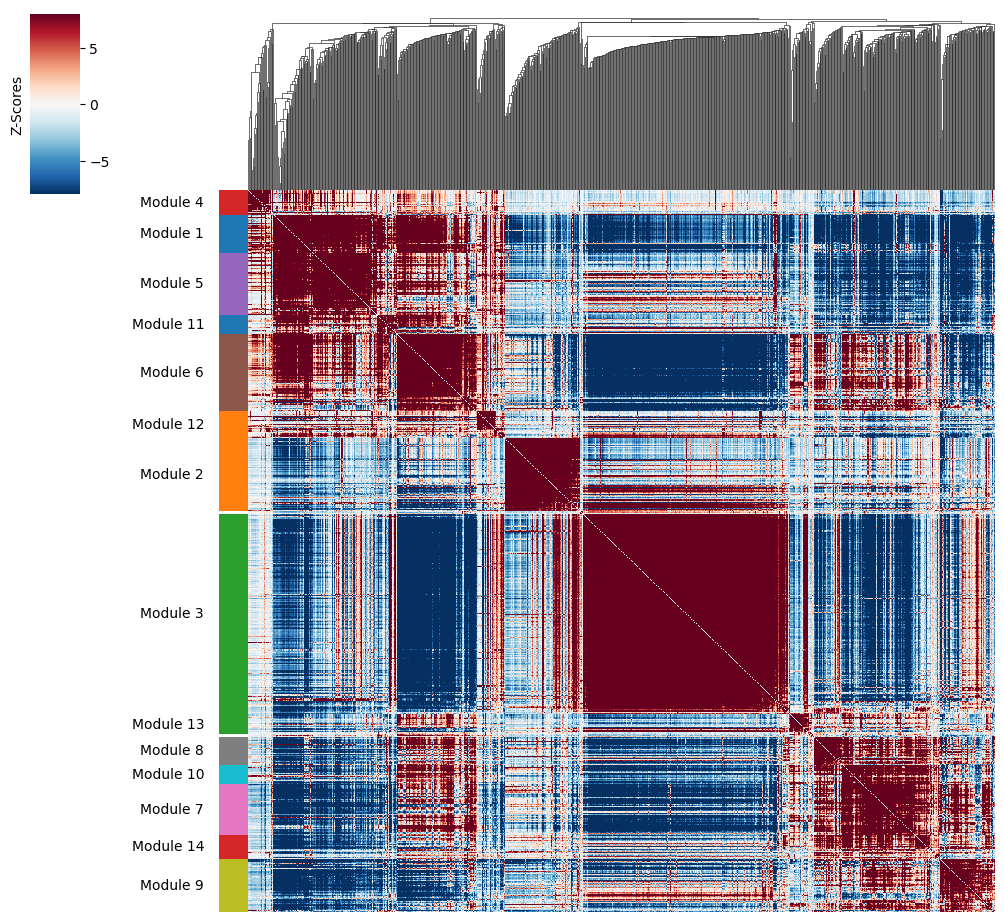

In [38]:
# plot 1：moudle_heatmap
plt.rcParams['figure.figsize'] = (16.0, 14.0) # Matplotlib 设置图形的默认尺寸
hs.plot_local_correlations() # Correlation modules can be visualized by running hs.plot_local_correlations()
plt.show()
plt.savefig(f'{chip}_heatmap', dpi = 600) 
plt.cla() # 清除当前的坐标轴(axes),但保留图形(figure). 通常在生成新图形之前使用
plt.clf() # 清除当前的图形(figure),即清除整个图形的内容
plt.close('all') # 关闭所有打开的图形窗口,释放内存.

In [39]:
# plot 2
figure_row = math.ceil(module_scores.shape[1] / 5) # 获取 module_scores DataFrame 的列数。表示模块的数量,确保每行有最多5个子图
figure_height = figure_row * 6
fig, axs = plt.subplots(figure_row, 5, figsize=(20, figure_height)) # plt.subplots(): 创建一个包含子图的图形对象
for ax, module in zip(axs.ravel(), range(1, hs.modules.max()+1)):
    scores = hs.module_scores[module]
    vmin = np.percentile(scores, 1) # 计算1%分位数，设定最小值
    vmax = np.percentile(scores, 99) # 计算99%分位数，设定最大值。这两个值用于规范化散点图中的颜色映射。
    plt.sca(ax) # 设置当前活动的坐标轴为ax，以便在这个坐标轴上绘图
    plt.scatter(x=hs.latent.iloc[:, 0],
                y=hs.latent.iloc[:, 1],
                s=6, # 散点的大小
                c=scores,
                vmin=vmin,
                vmax=vmax,
                edgecolors='none'
               )
    for sp in ax.spines.values():
        sp.set_visible(False) # 隐藏边框，以使图形更干净
    plt.xticks([]) # 隐藏x轴刻度标签
    plt.yticks([])
    plt.title('Module {}'.format(module))

plt.savefig(f"{chip}_All_Modules.png", dpi = 600)
plt.cla()
plt.clf()
plt.close('all')

In [42]:
# plot 3
plt.rcParams['figure.figsize'] = (42.0, 35.0)
hs.plot_local_correlations()
plt.savefig(f'{chip}_heatmap.png', dpi=300)
plt.cla()
plt.clf()
plt.close('all')
for module in range(1, hs.modules.max()+1):
    fig, ax = plt.subplots(figsize=(42.0, 35.0))
    scores = hs.module_scores[module]
    vmin = np.percentile(scores, 1)
    vmax = np.percentile(scores, 99)
    plt.scatter(x=hs.latent.iloc[:, 0],
                y=hs.latent.iloc[:, 1],
                s=8,
                c=scores,
                vmin=vmin,
                vmax=vmax,
                edgecolors='none'
               )
    plt.title('Module {}'.format(module), fontsize=60)
    plt.savefig("./split_module/Module_{}.png".format(module), dpi=300)
    plt.cla()
    plt.clf()
    plt.close('all')

In [44]:
# plot 4 :绘制每个基因模块中前 9 个基因的空间表达模式 ：颜色反转
matplotlib.use('Agg')
initial_cmap = cm.get_cmap('inferno') # 获取 Matplotlib 中的 'inferno' 颜色映射
reversed_cmap=initial_cmap.reversed() # 将获取的颜色映射反转，即颜色顺序反向排列

for module in range(1, hs.modules.max()+1):
    GeneModule  = results.loc[results.Module == module]
    genes = GeneModule.sort_values('Z', ascending=False).head(9).index # 将基因按 Z 值降序排列，取前9个基因的索引（基因名称）
    fig, axs = plt.subplots(3, 3, figsize=(12, 18)) # 创建一个包含 3x3 子图的图形对象 fig
    for ax, gene in zip(axs.ravel(), genes):
        vmax = adata[:,gene].to_df() # 提取 adata 中对应 gene 的数据，并转换为 DataFrame 格式
        vmax = np.percentile(vmax, 99.9)  # 计算基因表达值的 99.9% 分位数，用于确定颜色映射的最大值 vmax   
        plt.sca(ax) # 设置当前活动的坐标轴(axes) sca 代表 "Set Current Axes"
        sc.pl.spatial(adata, color=gene, spot_size=40, frameon = False, ax=ax, vmax=vmax, color_map  = reversed_cmap, basis= 'spatial')
        for sp in ax.spines.values(): # ax.spines 返回字典，包含了四个边框的 Spine 对象:('top'、'right'、'bottom'、'left')
            sp.set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.title(gene)
    plt.tight_layout() # 自动调整子图布局以填充整个图像区域
    plt.draw()  # 强制渲染图像
    plt.savefig('./split_module/Module{}_Top9Gene.png'.format(module), dpi=300)
    plt.close(fig)

In [ ]:
# # plot 4 :绘制每个基因模块中前 9 个基因的空间表达模式 ：颜色正常（有点不好看）
# initial_cmap = cm.get_cmap('inferno') # 获取 Matplotlib 中的 'inferno' 颜色映射
# #reversed_cmap=initial_cmap.reversed() # 将获取的颜色映射反转，即颜色顺序反向排列

# for module in range(1, hs.modules.max()+1):
#     GeneModule  = results.loc[results.Module == module]
#     genes = GeneModule.sort_values('Z', ascending=False).head(9).index # 将基因按 Z 值降序排列，取前9个基因的索引（基因名称）
#     fig, axs = plt.subplots(3, 3, figsize=(12, 18)) # 创建一个包含 3x3 子图的图形对象 fig
#     for ax, gene in zip(axs.ravel(), genes):
#         vmax = adata[:,gene].to_df() # 提取 adata 中对应 gene 的数据，并转换为 DataFrame 格式
#         vmax = np.percentile(vmax, 99.9)  # 计算基因表达值的 99.9% 分位数，用于确定颜色映射的最大值 vmax   
#         plt.sca(ax) # 设置当前活动的坐标轴(axes) sca 代表 "Set Current Axes"
#         sc.pl.spatial(adata, color=gene, spot_size=40, frameon = False, ax=ax, vmax=vmax, color_map  = initial_cmap, basis= 'spatial')
#         for sp in ax.spines.values(): # ax.spines 返回字典，包含了四个边框的 Spine 对象:('top'、'right'、'bottom'、'left')
#             sp.set_visible(False)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(gene)
#     plt.savefig('./split_module/Module{}_Top9Gene_col2.png'.format(module), dpi=300)
#     plt.cla()
#     plt.clf()
#     plt.close('all')